In [1]:
### Slurm queue sims for Symmetry

In [4]:
%matplotlib inline
import pylab as plt
import numpy as np
from collections import Counter

In [5]:
jobid = 1
class Job(object):
    def __init__(self, user, submit_time):
        global jobid
        self.user = user
        self.subtime = submit_time
        self.jobid = jobid
        jobid += 1

In [53]:
# Slurm & cluster configuration
# How many nodes in the cluster?  Here, ~70 for the defq on Symmetry
nnodes = 70
# HOWEVER, it turns out that in *these* simulations, in each time step we always end up
# scheduling only one user's jobs, so the whole thing just scales, so we can set this to 1
# and have the sims run much faster!

# This is the effective number of users as far as Slurm is concerned -- eg, `sshare`
nusers = 168

# Slurm config parameters
priority_max_age = 10 * 24
priority_weight_age = 10000
priority_decay_halflife = 7 * 24
fair_share_dampening_factor = 20
priority_D = np.exp(np.log(0.5) / priority_decay_halflife)


# Parameters for different runs:
nnodes = 1

#config = '1'
#priority_weight_fairshare = 4000

#config = '2'
#priority_weight_fairshare = 10000

#config = '3'
#priority_weight_fairshare = 100000
#nnodes = 1

# Run 4: long-term behavior with 2 big users and large fair-share weight.
config = '4'
priority_weight_fairshare = 100000

In [54]:
if config in ['1', '2', '3']:
    # ~2 weeks worth of jobs for User 1.
    queue = []
    user=1
    for i in range(7 * 24 * nnodes * 2):
        queue.append(Job(user, 0))
    # a week later, queue ~12,000 jobs for user 1
    t = 7*24
    user=2
    for i in range(7 * 24 * nnodes):
        queue.append(Job(user, t))

elif config == '4':
    # ~4 weeks worth of jobs for User 1.
    queue = []
    user=1
    for i in range(7 * 24 * nnodes * 4):
        queue.append(Job(user, 0))
    # a week later, queue 3 weeks of jobs for User 2.
    t = 7*24
    user=2
    for i in range(7 * 24 * nnodes * 3):
        queue.append(Job(user, t))

In [55]:
# run!
# find unique users
users = set()
for j in queue:
    users.add(j.user)
users = list(users)
user_map = dict([u,i] for i,u in enumerate(users))
finished = []
usage = np.zeros(len(users))
nrunning_history = []
damped_usage_history = []
fair_share_history = []
user_max_priority_history = []
user_max_age_history = []
t_now = 0
while len(queue):
    # compute priorities
    shares = np.ones(len(users)) / float(nusers)
    fair_share = 2.**(-usage/shares/fair_share_dampening_factor)
    fair_share_map = dict([(u,fs) for u,fs in zip(users, fair_share)])
    waiting_jobs = [j for j in queue if j.subtime <= t_now]
    job_fair_share = np.array([fair_share_map[j.user] for j in waiting_jobs])
    job_age = np.array([(t_now - j.subtime) / priority_max_age for j in waiting_jobs])
    # job_age maxes out at 1.0
    job_age = np.minimum(job_age, 1.0)
    priority = job_fair_share * priority_weight_fairshare + job_age * priority_weight_age
    user_max_priority = np.zeros(len(users))
    user_max_age = np.zeros(len(users))
    for p,a,j in zip(priority, job_age, waiting_jobs):
        iuser = user_map[j.user]
        user_max_priority[iuser] = max(user_max_priority[iuser], p)
        user_max_age[iuser] = max(user_max_age[iuser], a)
    user_max_priority_history.append(user_max_priority)
    user_max_age_history.append(user_max_age)
    
    Iprio = np.argsort(-priority)
    to_run = [waiting_jobs[i] for i in Iprio[:nnodes]]
    for j in to_run:
        j.runtime = t_now
    this_usage = np.zeros(len(users))
    ujobs = Counter([j.user for j in to_run])
    #print('Time step', t_now, ': running jobs for users:', ujobs.most_common())
    for u,n in ujobs.items():
        this_usage[user_map[u]] = n/nnodes
    usage = usage * priority_D + (1.-priority_D)*this_usage
    nrunning_history.append(this_usage)
    damped_usage_history.append(usage.copy())
    fair_share_history.append(fair_share.copy())
    for j in to_run:
        queue.remove(j)
        finished.append(j)
    t_now += 1
nrunning_history = np.array(nrunning_history)
user_max_priority_history = np.array(user_max_priority_history)
user_max_age_history = np.array(user_max_age_history)
fair_share_history = np.array(fair_share_history)

In [56]:
weeks = np.arange(t_now)/(7*24)
cc=['b','orange','g']

nweeks = int(np.ceil(max(weeks)))+1
def plot_decorate():
    for i in range(nweeks):
        plt.axvline(i, color='k', alpha=0.25)
    plt.xlabel('Time (weeks)')
    plt.xticks(np.arange(nweeks))

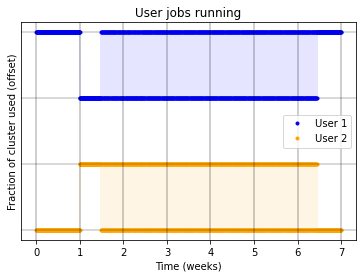

In [57]:
for i in range(len(users)):
    yoff = (len(users)-1-i)*2
    plt.plot(weeks, yoff + nrunning_history[:,i], '-', alpha=0.1, color=cc[i]);
    plt.plot(weeks, yoff + nrunning_history[:,i], '.', color=cc[i], label='User %i'%(i+1));
    plt.axhline(yoff, color='k', alpha=0.2)
    plt.axhline(yoff+1, color='k', alpha=0.2)
plot_decorate()
plt.yticks([])
plt.ylabel('Fraction of cluster used (offset)')
plt.legend();
plt.title('User jobs running');

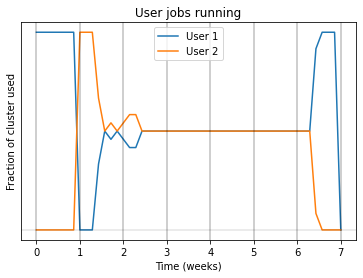

In [58]:
ndays = 1 + t_now//24
days = np.arange(ndays)
nt,nu = nrunning_history.shape
nrunning_daily = np.zeros((ndays,nu))
for i in range(ndays):
    nrunning_daily[i,:] = np.sum(nrunning_history[i*24:(i+1)*24,:], axis=0)
for i in range(len(users)):
    plt.plot(days/7., nrunning_daily[:,i], '-', #color=cc[i],
             label='User %i'%(i+1));
    if i == 2:
        I = np.flatnonzero(nrunning_daily[:,i] > 0)
        plt.plot(days[I]/7., nrunning_daily[I,i], 'o', color=cc[i])        
plot_decorate()
plt.axhline(0, color='k', alpha=0.1)
plt.yticks([])
plt.ylabel('Fraction of cluster used')
plt.legend();
plt.title('User jobs running');
plt.savefig('sim-%s-ujobs.png' % config)

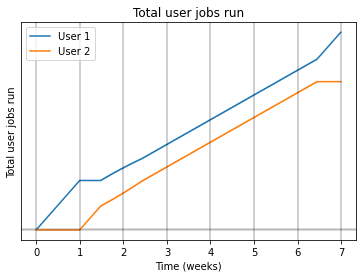

In [59]:
for i in range(len(users)):
    yoff = (len(users)-1-i)*2
    plt.plot(weeks, np.cumsum(nrunning_history[:,i]), '-', #color=cc[i],
             label='User %i'%(i+1));
    plt.axhline(yoff, color='k', alpha=0.2)
plot_decorate()
plt.yticks([])
plt.ylabel('Total user jobs run')
plt.legend();
plt.title('Total user jobs run');

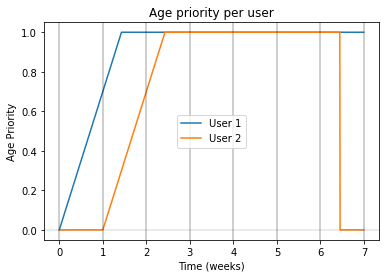

In [60]:
for i in range(len(users)):
    plt.plot(weeks, user_max_age_history[:,i], label='User %i'%(i+1));
plt.legend()
plot_decorate()
plt.ylabel('Age Priority');
plt.title('Age priority per user');
plt.axhline(0, color='k', alpha=0.1)
plt.savefig('sim-%s-age.png' % config)

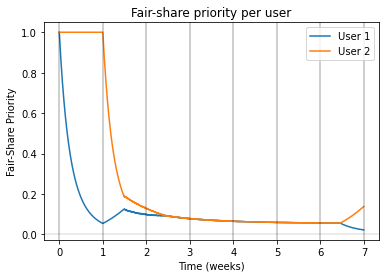

In [61]:
for i in range(len(users)):
    plt.plot(weeks, fair_share_history[:,i], label='User %i'%(i+1));
plt.legend()
plot_decorate()
plt.axhline(0, color='k', alpha=0.1)
plt.ylabel('Fair-Share Priority');
plt.title('Fair-share priority per user');
plt.savefig('sim-%s-fairshare.png' % config);

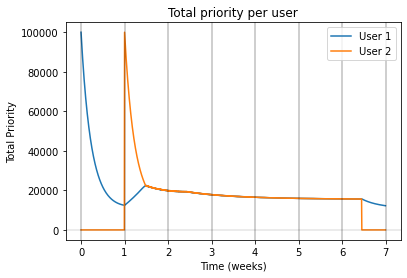

In [62]:
for i in range(len(users)):
    plt.plot(weeks, user_max_priority_history[:,i], label='User %i'%(i+1));
plt.legend()
plot_decorate()
plt.axhline(0, color='k', alpha=0.1)
plt.ylabel('Total Priority');
plt.title('Total priority per user');
plt.savefig('sim-%s-prio.png' % config);